### Verify GPU is available

In [1]:
!nvidia-smi

Thu Nov 14 02:46:52 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P8              12W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

### pip installation

In [2]:
!pip install umap-learn

In [3]:
!pip install \
    --extra-index-url=https://pypi.nvidia.com \
    cudf-cu12==24.10.* dask-cudf-cu12==24.10.* cuml-cu12==24.10.* \
    cugraph-cu12==24.10.* nx-cugraph-cu12==24.10.* cuspatial-cu12==24.10.* \
    cuproj-cu12==24.10.* cuxfilter-cu12==24.10.* cucim-cu12==24.10.* \
    pylibraft-cu12==24.10.* raft-dask-cu12==24.10.* cuvs-cu12==24.10.* \
    nx-cugraph-cu12==24.10.*

Looking in indexes: https://pypi.org/simple, https://pypi.nvidia.com


### Imports

In [ ]:
from time import time
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# CPU-only
from sklearn.manifold import TSNE
from umap.umap_ import UMAP

# GPU-accelerated
from cuml.manifold import TSNE as cumlTSNE
from cuml.manifold import UMAP as cumlUMAP



## Pre-execution

### Load datas

In [5]:
print("1. Chargement des données...")
columns = [
    "Elevation",
    "Aspect",
    "Slope",
    "Horizontal_Distance_To_Hydrology",
    "Vertical_Distance_To_Hydrology",
    "Horizontal_Distance_To_Roadways",
    "Hillshade_9am",
    "Hillshade_Noon",
    "Hillshade_3pm",
    "Horizontal_Distance_To_Fire_Points",
    "Wilderness_Area1",
    *[f"Soil_Type_{i}" for i in range(1, 40)],
    "Cover_Type"
]

print(columns)

data = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/covtype/covtype.data.gz', header=None, names=columns)

1. Chargement des données...
['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways', 'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm', 'Horizontal_Distance_To_Fire_Points', 'Wilderness_Area1', 'Soil_Type_1', 'Soil_Type_2', 'Soil_Type_3', 'Soil_Type_4', 'Soil_Type_5', 'Soil_Type_6', 'Soil_Type_7', 'Soil_Type_8', 'Soil_Type_9', 'Soil_Type_10', 'Soil_Type_11', 'Soil_Type_12', 'Soil_Type_13', 'Soil_Type_14', 'Soil_Type_15', 'Soil_Type_16', 'Soil_Type_17', 'Soil_Type_18', 'Soil_Type_19', 'Soil_Type_20', 'Soil_Type_21', 'Soil_Type_22', 'Soil_Type_23', 'Soil_Type_24', 'Soil_Type_25', 'Soil_Type_26', 'Soil_Type_27', 'Soil_Type_28', 'Soil_Type_29', 'Soil_Type_30', 'Soil_Type_31', 'Soil_Type_32', 'Soil_Type_33', 'Soil_Type_34', 'Soil_Type_35', 'Soil_Type_36', 'Soil_Type_37', 'Soil_Type_38', 'Soil_Type_39', 'Cover_Type']


### Split datas

In [6]:
X=data.drop('Cover_Type', axis=1)
y=data['Cover_Type']

# Diviser les données
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Standardize datas

In [7]:
# Standardiser les données
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Fonctions

In [8]:
custom_cmap = ListedColormap(plt.cm.tab10.colors[:7])

# Fonction de visualisation
def visualize_embeddings(X, y, title):
    plt.figure(figsize=(10, 8))
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=custom_cmap, s=1)
    plt.colorbar()
    plt.title(title)
    plt.show()

In [9]:
# convert second to mm:ss

def convert(seconds):
    minutes = seconds // 60
    seconds %= 60
    return "%02d:%02d" % (minutes, seconds)

## Computing

In [10]:
# Get reduced datasets
print("2. Réduction de la dimensionnalité...")

n = 3000

X_train_scaled_small = X_train_scaled[:n]
y_train_small = y_train[:n]

2. Réduction de la dimensionnalité...


In [11]:
# Compute T-SNE (CPU)

time_tsne_cpu = time()

tsne = TSNE(n_components=2, random_state=42)
X_tsne_cpu = tsne.fit_transform(X_train_scaled_small)

time_tsne_cpu = time() - time_tsne_cpu

In [12]:
# Compute T-SNE (GPU)

time_tsne_gpu = time()

tsneGPU = cumlTSNE(n_components=2, random_state=42)
X_tsne_gpu = tsneGPU.fit_transform(X_train_scaled_small)

time_tsne_gpu = time() - time_tsne_gpu


/usr/local/lib/python3.10/dist-packages/cuml/internals/api_decorators.py:382: UserWarning: Starting from version 22.04, the default method of TSNE is 'fft'.
  return init_func(self, *args, **filtered_kwargs)


In [13]:
# Compute UMAP (CPU)

time_umap_cpu = time()

umapCPU = UMAP(n_components=2, random_state=42)
X_umap_cpu = umapCPU.fit_transform(X_train_scaled_small)

time_umap_cpu = time() - time_umap_cpu

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [14]:
# Compute UMAP (GPU)

time_umap_gpu = time()

umapGPU = cumlUMAP(n_components=2, random_state=42)
X_umap_gpu = umapGPU.fit_transform(X_train_scaled_small)

time_umap_gpu = time() - time_umap_gpu

## Visualisation

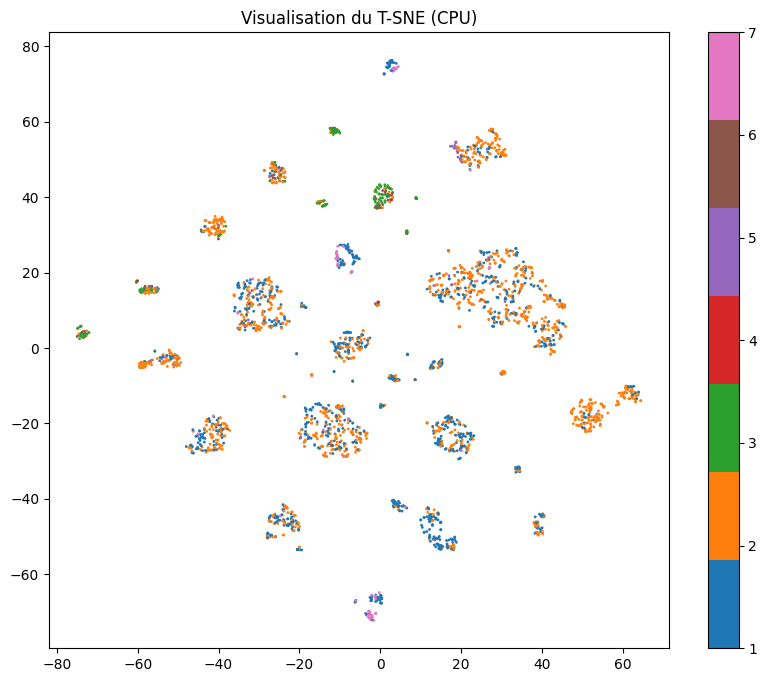

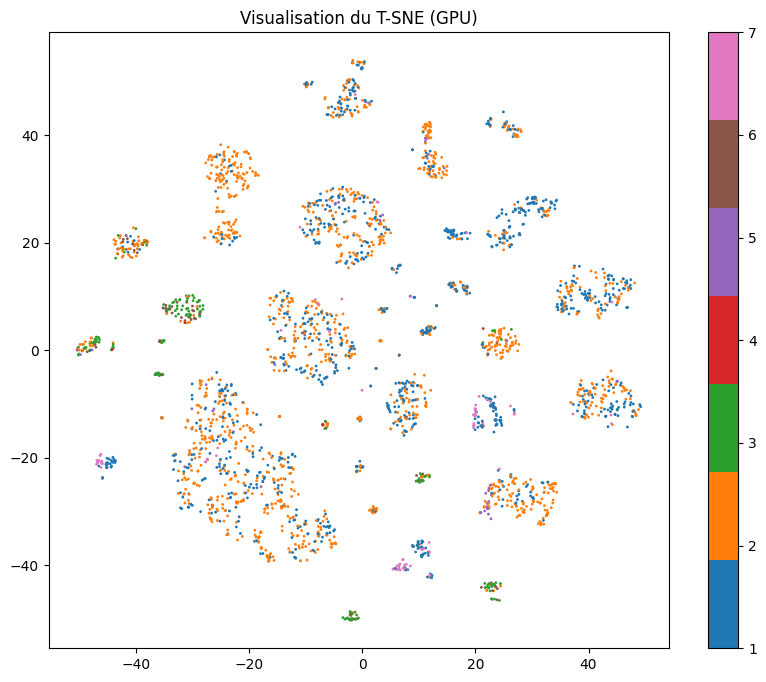

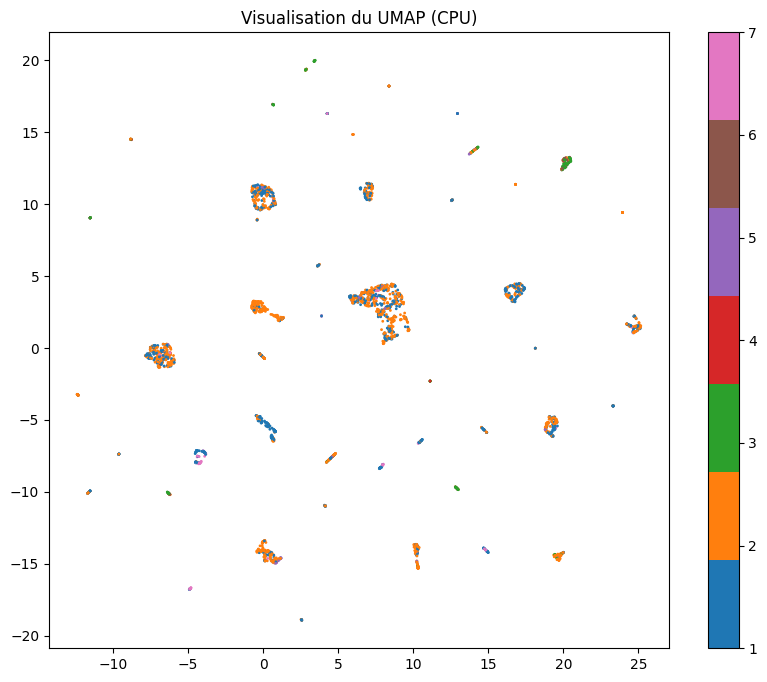

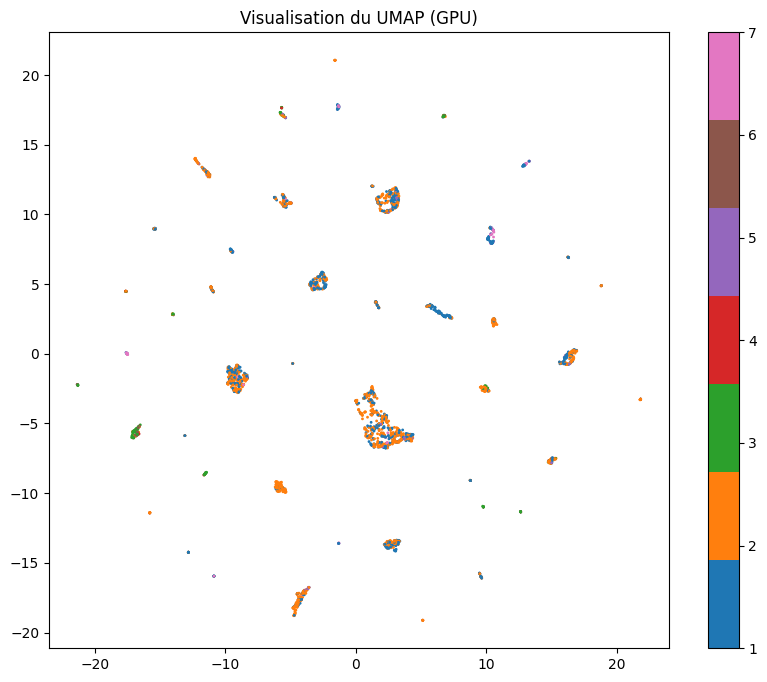

In [15]:

visualize_embeddings(X_tsne_cpu, y_train_small, 'Visualisation du T-SNE (CPU)')
visualize_embeddings(X_tsne_gpu, y_train_small, 'Visualisation du T-SNE (GPU)')
visualize_embeddings(X_umap_cpu, y_train_small, 'Visualisation du UMAP (CPU)')
visualize_embeddings(X_umap_gpu, y_train_small, 'Visualisation du UMAP (GPU)')

## Results

In [ ]:
print(f"Comparaison for {n} samples")
print("---- T-SNE ----")
print(f"CPU: {convert(time_tsne_cpu)}")
print(f"GPU: {convert(time_tsne_gpu)}")
print("---- UMAP ----")
print(f"CPU: {convert(time_umap_cpu)}")
print(f"GPU: {convert(time_umap_gpu)}")

Comparaison for {n} samples
---- T-SNE ----
CPU: 00:38
GPU: 00:01
---- UMAP ----
CPU: 00:19
GPU: 00:00
